# Objetivo do Modelo


Inicialmente, o objetivo do modelo é prever o número de likes que um tweet receberá. Isso ajuda a estimar o engajamento esperado e otimizar estratégias de postagem para maximizar a interação. O modelo usa características dos tweets, como o horário e o dia da semana, para fazer essas previsões, e a precisão é avaliada usando métricas como RMSE.

# Importando as Bibliotecas

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Download do Dataset do Twitter

In [60]:
# Carregando o dataset
df= pd.read_csv("/content/tweets-engagement-metrics.csv")
df = df.drop('Unnamed: 0', axis=1)

In [61]:
df.head()

,UserID,Gender,LocationID,City,State,StateCode,Country,TweetID,Hour,Day,Weekday,IsReshare,Reach,RetweetCount,Likes,Klout,Sentiment,Lang,text
0,tw-1267804344,Unknown,1.0,Elbasan,Elbasan,AL,Albania,tw-698155297102295041,7,12,Friday,True,339.0,127.0,0.0,44.0,0.0,en,"""RT @AdrianRusso82: Our Innovation Lab is offi..."
1,tw-27229880,Male,2.0,Tirana,Tirane,AL,Albania,tw-685159757209059329,11,7,Thursday,False,87.0,0.0,0.0,22.0,0.0,en,Now Open AWS Asia Pacific (Seoul) Region via ...
2,tw-27229880,Male,2.0,Tirana,Tirane,AL,Albania,tw-686907710311378944,6,12,Tuesday,False,87.0,0.0,0.0,22.0,0.0,en,A Beginner's Guide to Scaling to 11 Million+ U...
3,tw-27229880,Male,2.0,Tirana,Tirane,AL,Albania,tw-686968158050201600,10,12,Tuesday,False,87.0,0.0,0.0,22.0,0.0,en,Bridging AWS and Azure environments via VPN vi...
4,tw-27229880,Male,2.0,Tirana,Tirane,AL,Albania,tw-690210449674092545,9,21,Thursday,False,85.0,0.0,0.0,21.0,0.0,en,ELK on AWS ElasticSearch Service + ElasticBean...


## Descrição das Colunas das Tabelas

- **`UserID`**: Identificador único do usuário que postou o tweet. Pode ser usado para analisar padrões de engajamento por usuário.

- **`Gender`**: Gênero do usuário. Pode ser categórico (por exemplo, "Masculino", "Feminino") e pode ser usado para análise demográfica.

- **`LocationID`**: Identificador da localização geográfica do usuário. Pode estar associado a uma base de dados de localizações para análise regional.

- **`City`**: Nome da cidade onde o usuário está localizado. Útil para análise geográfica e identificação de padrões regionais.

- **`State`**: Nome do estado onde o usuário está localizado. Ajuda na análise regional dentro de um país.

- **`StateCode`**: Código do estado, geralmente uma abreviação padrão. Facilita a análise e agregação de dados por estado.

- **`Country`**: Nome do país onde o usuário está localizado. Importante para análise internacional e comparação entre países.

- **`TweetID`**: Identificador único do tweet. Utilizado para distinguir e rastrear tweets específicos.

- **`Hour`**: Hora do dia em que o tweet foi postado. Usado para analisar padrões de engajamento ao longo do dia.

- **`Day`**: Dia do mês em que o tweet foi postado. Ajuda a identificar padrões diários e tendências de engajamento.

- **`Weekday`**: Dia da semana em que o tweet foi postado. Facilita a análise de tendências semanais e variações de engajamento durante a semana.

- **`IsReshare`**: Indicador de se o tweet é um compartilhamento (retweet). Pode ser usado para diferenciar entre tweets originais e compartilhados.

- **`Reach`**: Alcance do tweet, ou seja, o número de usuários únicos que visualizaram o tweet. Mede a visibilidade do tweet.

- **`RetweetCount`**: Número de vezes que o tweet foi retweetado. Indica o nível de compartilhamento e popularidade.

- **`Likes`**: Número de curtidas no tweet. Mede o engajamento direto dos usuários com o tweet.

- **`Klout`**: Pontuação Klout do usuário, uma métrica de influência nas redes sociais. Ajuda a analisar o impacto de usuários influentes.

- **`Sentiment`**: Sentimento associado ao tweet, que pode ser categórico (por exemplo, "Positivo", "Negativo", "Neutro"). Útil para análise de opinião e sentimento geral.

- **`Lang`**: Idioma em que o tweet foi escrito. Importante para análise linguística e segmentação de dados por idioma.

- **`text`**: Conteúdo textual do tweet. Essencial para análises de conteúdo, processamento de linguagem natural (NLP) e modelagem de tópicos.

# Implementação do Modelo do RNN

## Pré-Processamento

In [62]:
# Eliminando os valores iguais a 0 com fins de melhora do modelo para predição
df = df[df['Likes'] != 0]

In [63]:
# Reogarnizando os índices do dataset
df.reset_index(drop=True, inplace=True)

In [64]:
# Codificação da coluna 'Weekday' usando OneHotEncoder
encoder = OneHotEncoder(sparse=False)
weekdays_encoded = encoder.fit_transform(df[['Weekday']])
weekdays_encoded_df = pd.DataFrame(weekdays_encoded, columns=encoder.get_feature_names_out(['Weekday']))

# Adicionando as colunas codificadas ao DataFrame original
df = pd.concat([df, weekdays_encoded_df], axis=1)

# Removendo a coluna original 'Weekday'
df = df.drop(columns=['Weekday'])

# Convertendo colunas para tipo float
df['Hour'] = df['Hour'].astype(float)
df['Day'] = df['Day'].astype(float)
df['IsReshare'] = df['IsReshare'].astype(float)

In [65]:
df.head()

,UserID,Gender,LocationID,City,State,StateCode,Country,TweetID,Hour,Day,...,Sentiment,Lang,text,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,tw-66780587,Unknown,3751.0,Seattle,Washington,US-WA,United States,tw-683367429049683968,12.0,2.0,...,0.0,en,Use a highly available NAT gateway to give pri...,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,tw-66780587,Unknown,3751.0,Seattle,Washington,US-WA,United States,tw-683425549549584384,16.0,2.0,...,0.0,en,New usage examples have been added to the CLI ...,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,tw-66780587,Unknown,3751.0,Seattle,Washington,US-WA,United States,tw-683724013797965824,11.0,3.0,...,0.0,en,Copy AMIs from another AWS account in the same...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,tw-66780587,Unknown,3751.0,Seattle,Washington,US-WA,United States,tw-683783168235720704,15.0,3.0,...,0.0,en,New usage examples have been added to the CLI ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,tw-66780587,Unknown,3751.0,Seattle,Washington,US-WA,United States,tw-684144536868618240,15.0,4.0,...,2.0,en,Use the examples added for the CodePipeline AP...,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Seleção de Features

In [66]:
# Ajustando os valores que determinam o tempo para features
features = df[['Hour', 'Day'] + list(encoder.get_feature_names_out(['Weekday'])) + ['IsReshare']]
# Selecionando a coluna target
target = df['Likes']

## Preparando as Sequências

In [67]:
# Normalização dos dados
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Preparação dos dados para a RNN
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

## Separando Dados de Treino e Teste

In [68]:
seq_length = 10
X, y = create_sequences(features_scaled, target, seq_length)

# Dividindo os dados em treinamento e teste
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Arquitetura de Modelo

O modelo usa uma camada RNN para entender padrões temporais nos dados e uma camada densa para gerar a previsão final do número de likes.

In [69]:
# Arquitetura RNN simplificada
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    tf.keras.layers.Dense(1)
])

In [70]:
model.compile(optimizer='adam', loss='mean_squared_error')

## Treinamento do Modelo

In [71]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1326.0372 - val_loss: 1390.2360
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1287.7714 - val_loss: 1030.1829
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 510.0800 - val_loss: 742.2606
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 469.4424 - val_loss: 686.0479
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 474.5753 - val_loss: 595.6098
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 400.3711 - val_loss: 513.9926
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 344.7308 - val_loss: 475.6694
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 420.5704 - val_loss: 484.9892
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 399.7479 - val_loss: 490.0799
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 375.7882 - val_loss: 470.7296
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 364.6176 - val_loss: 458.9359
Epoch 12/20
12/12 ━━━━

## Escolha da Métrica e da Loss

Para o problema de previsão do número de likes em tweets, o Root Mean Squared Error (RMSE) é escolhido como métrica porque fornece uma avaliação clara e intuitiva da precisão das previsões. O RMSE é expresso na mesma unidade dos likes, facilitando a interpretação dos erros e penaliza mais severamente os erros grandes, o que ajuda a identificar previsões muito imprecisas.

A função de perda escolhida é o Mean Squared Error (MSE), que calcula a média dos erros quadráticos entre as previsões e os valores reais. A MSE é simples e eficaz para problemas de regressão, e sua raiz quadrada, o RMSE, é a métrica utilizada para avaliar o modelo. Usar MSE como função de perda garante que o modelo seja otimizado de acordo com a métrica que será utilizada para avaliar sua performance, proporcionando consistência entre o treinamento e a avaliação do modelo.

## Predição e Gráficos

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
RMSE: 19.10457987527044


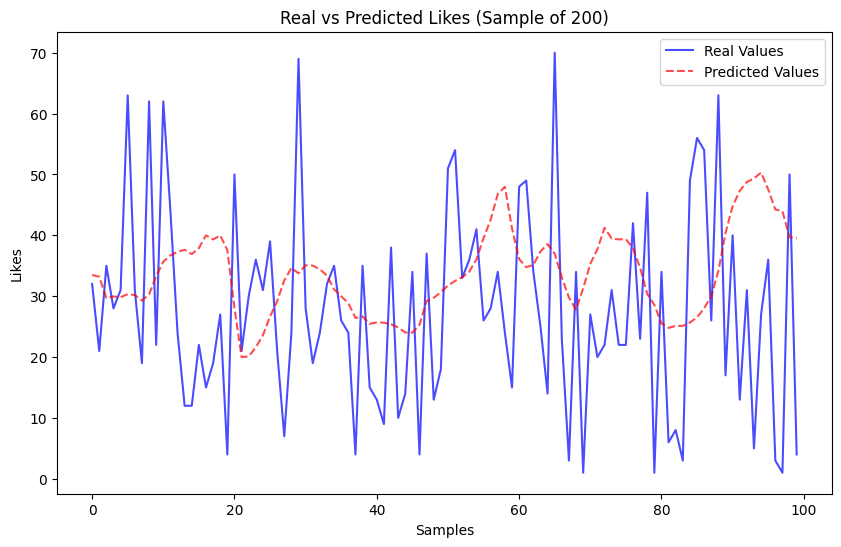

In [72]:
# Fazendo previsões com o modelo usando o conjunto de dados de teste
y_pred = model.predict(X_test)

# Calculando o erro quadrático médio (RMSE) entre os valores reais e as previsões
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Exibindo o valor da métrica RMSE
print(f'RMSE: {rmse}')

# Definindo o tamanho da amostra para plotar os gráficos
sample_size = 200

# Criando uma figura para o gráfico
plt.figure(figsize=(10, 6))

# Plotando os valores reais das primeiras 200 amostras
plt.plot(y_test[:sample_size], label='Real Values', color='blue', alpha=0.7)

# Plotando os valores preditos das primeiras 200 amostras
plt.plot(y_pred[:sample_size], label='Predicted Values', color='red', linestyle='--', alpha=0.7)

# Adicionando título ao gráfico
plt.title('Real vs Predicted Likes (Sample of 200)')

# Adicionando rótulos aos eixos
plt.xlabel('Samples')
plt.ylabel('Likes')

# Adicionando legenda para identificar as linhas no gráfico
plt.legend()

# Exibindo o gráfico
plt.show()

## Análise dos Resultados

As oscilações entre os valores preditos e reais no gráfico indicam que o modelo não está conseguindo capturar de forma consistente as variações nos dados.